# Introduction to kinetic modeling with SBML

Kinetic modeling based on ordinary differential equations (ODE) plays an important role in computational biology. An important aspect of such models is its reusability and the reproducibility of the results. An important step towards reproducible and understandable models was the introduction of standard formats for model description (SBML, CellML, BioPax) and guidlines for model description (MIRIAM) and simulation description (MIASE) were developed. These standards are currently supported by a wide range of libraries and software tools, providing a rich environment for the work with such models.  
In addition to standard formats, IPython notebooks provide the visual framework for representing model setup, simulation and results in a unified and reproducible way.

This notebook demonstrates the basic work with computational models based on the Systems Biology Markup Language (SBML), the de facto standard for kinetic models in biology.  
As part of the introduction standard tools in python for the interaction with SBML based models are presented, like libSBML, Antimony and RoadRunner. ODE simulations are demonstrated.


### How to Use the Examples
TODO: update and provide the examples.


* Make sure your machine already has Python and related libraries, such as ipython, numpy, scipy, pandas, etc.
* Start Cytoscape (cyREST should be installed!)
* Clone the repository: git clone https://github.com/idekerlab/cy-rest-python
* Change directory: cd cy-rest-python
* Start IPython Notebook: `ipython notebook`
* Click index.ipynb to start the example



In [1]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## libSBML
An important part of the work with SBML is the possibilty to modify models.  
Some GUI based modeling environments are available, like CellDesigner or BioUML.  
To programatically interact with SBML the SBML library libSBML (http://www.sbml.org) is the option of choice.

In [2]:
!ls    # available files

demo_basic.html			  galactose_multiscale.ipynb
demo_basic.ipynb		  galactose_parameter_sensitivity.ipynb
demo_django.html		  __init__.py
demo_django.ipynb		  README.md
demo_graph.html			  test_simulation_strategies.html
demo_graph.ipynb		  test_simulation_strategies.ipynb
demo_mca.ipynb			  Untitled.ipynb
demo_parameter_sensitivity.html   van_der_pol.html
demo_parameter_sensitivity.ipynb  van_der_pol.ipynb


Loading model with libsbml and inspect main model features.

In [3]:
import libsbml
from multiscale.examples import testdata
print(testdata.demo_sbml)
doc = libsbml.readSBMLFromFile(testdata.demo_sbml) 
model = doc.getModel()
print(model)

/home/mkoenig/git/multiscale-galactose/python/multiscalepy/multiscale/examples/models/demo/Koenig_demo_10_annotated.xml
<Model Koenig_demo_10_annotated "Koenig_demo_10">


Print model information like model id, and listOfSpecies

In [4]:
print(model.getId())
print('-' * 80)

compartments = model.getListOfCompartments()
for c in compartments:
    print(c)
    print(c.name, c.units)
print('-' * 80)

species = model.getListOfSpecies()
for s in species:
    print(s)
print('-' * 80)
    
reactions = model.getListOfReactions()
for r in reactions:
    print(r)

Koenig_demo_10_annotated
--------------------------------------------------------------------------------
<Compartment e "external compartment">
external compartment m3
<Compartment c "cell compartment">
cell compartment m3
<Compartment m "plasma membrane">
plasma membrane m2
--------------------------------------------------------------------------------
<Species e__A "A">
<Species e__C "C">
<Species e__B "B">
<Species c__C "C">
<Species c__B "B">
<Species c__A "A">
--------------------------------------------------------------------------------
<Reaction bA "bA (A import)">
<Reaction bB "bB (B export)">
<Reaction bC "bC (C export)">
<Reaction v1 "v1 (A -> B)">
<Reaction v2 "v2 (A -> C)">
<Reaction v3 "v3 (C -> A)">
<Reaction v4 "v4 (C -> B)">


### Using libSBML to generate a simple graph of the network

For a very simple visualization of the network we can read the graph from the species and reactions.  
TODO: provide example with networkX

## Antimony

Antimony is a tools for SBML which provides human readable representation of the SBML information.
Loading SBML with Antimony and get human readable representation of the information.

In [5]:
import antimony
antimony.loadSBMLFile(testdata.demo_sbml)
mod_names = antimony.getModuleNames()
print(mod_names)
ant_string = antimony.getAntimonyString(mod_names[1])
print(ant_string)

('__main', 'Koenig_demo_10_annotated')
// Created by libAntimony v2.8.1
model *Koenig_demo_10_annotated()

  // Compartments and Species:
  compartment e, c;
  species e__A in e, e__C in e, e__B in e, c__C in c, c__B in c, c__A in c;

  // Reactions:
  bA: e__A => c__A; (scale_f*(Vmax_bA/Km_A)*(e__A - c__A))/(1 dimensionless + e__A/Km_A + c__A/Km_A);
  bB: c__B => e__B; (scale_f*(Vmax_bB/Km_B)*(c__B - e__B))/(1 dimensionless + e__B/Km_B + c__B/Km_B);
  bC: c__C => e__C; (scale_f*(Vmax_bC/Km_C)*(c__C - e__C))/(1 dimensionless + e__C/Km_C + c__C/Km_C);
  v1 in c: c__A => c__B; (scale_f*Vmax_v1)/Km_A*(c__A - 1 dimensionless/Keq_v1*c__B);
  v2 in c: c__A => c__C; (scale_f*Vmax_v2)/Km_A*c__A;
  v3 in c: c__C => c__A; (scale_f*Vmax_v3)/Km_A*c__C;
  v4 in c: c__C => c__B; (scale_f*Vmax_v4)/Km_A*(c__C - 1 dimensionless/Keq_v4*c__B);

  // Species initializations:
  e__A = 10;
  e__A has mM;
  e__C = 0;
  e__C has mM;
  e__B = 0;
  e__B has mM;
  c__C = 0;
  c__C has mM;
  c__B = 0;
  c__B has 

### Creating models with Antimony

Antimony provides a simple syntax to define models in text.

In [6]:
import antimony
print(antimony.LIBANTIMONY_VERSION_STRING)

model_str = '''
# Simple UniUni reaction with first-order mass-action kinetics
model example1
  S1 -> S2; k1*S1
  S1 = 10
  S2 = 0
  k1 = 0.1
end
'''

# Load model string
res = antimony.loadAntimonyString(model_str)
if (res == -1):
    print(antimony.getLastError())

# SBML is created based on module name
module_name = antimony.getMainModuleName()
print(antimony.getSBMLString(module_name))

v2.8.0
<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by libAntimony version v2.8.1 on 2016-01-20 09:50 with libSBML version 5.12.1. -->
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model id="example1" name="example1">
    <listOfCompartments>
      <compartment sboTerm="SBO:0000410" id="default_compartment" spatialDimensions="3" size="1" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="default_compartment" initialConcentration="10" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="default_compartment" initialConcentration="0" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="k1" value="0.1" constant="true"/>
    </listOfParameters>
    <listOfReactions>
      <reaction id="_J0" reversible="true" fast="false">
        <listOfReactants>
      

## RoadRunner simulations

Example simulations with the demo network.
First import roadrunner for simulations.

In [7]:
import roadrunner
roadrunner.getVersionStr()

'1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Jan 20 2016, 08:49:40'

Loading the model and performing a simple time course simulation.

['time', '[e__A]', '[e__C]', '[e__B]', '[c__C]', '[c__B]', '[c__A]']


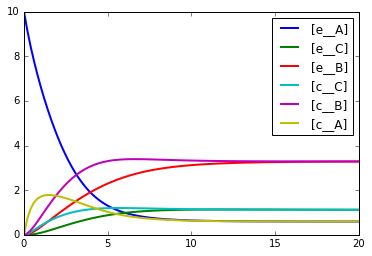

(100, 7)

In [8]:
# load model and generate equidistant timecourse for 20 [s]
r = roadrunner.RoadRunner(testdata.demo_sbml)
r.selections = ['time'] + ['[{}]'.format(s) for s in r.model.getFloatingSpeciesIds()]
print(r.selections)

result = r.simulate(0,20, 100, plot=True)
result.shape

In [ ]:
print(result)

In [ ]:
result.shape

In [ ]:
# plot some concentrations against each other
plt.plot(result['[c__A]'], result['[e__A]'], '-o', color='black', label="A_ext ~ A")
plt.plot(result['[c__B]'], result['[e__B]'], '-o', color='red', label="B_ext ~ B")
plt.plot(result['[c__C]'], result['[c__C]'], '-o', color='blue', label="C_ext ~ C")
plt.xlabel('Cell concentration [mM]')
plt.ylabel('External concentration [mM]')
plt.title('Trajectories of A, B, C')
plt.legend();

### Selections

The content of the numerical output is defined via selections. Via selections the, components of the model we are interested in can be selected.
Currently only the time and all concentrations of the model are selected.

In [ ]:
print(r.selections)

In [ ]:
# get all the compartment volumes at end point
print(type(r.model.getCompartmentVolumes()))
print(r.model.getCompartmentIds())
print(r.model.getCompartmentVolumes())

In [ ]:
# get all the reactionRates at end point
print(r.model.getReactionIds())
print(r.model.getReactionRates())

Now we are interested in the rates. Adding them to the selection, and plot them.

In [ ]:
r.selections = ['time'] + r.model.getReactionIds()

In [ ]:
r.reset()  # reset initial concentrations
s  = r.simulate(0,20, plot=False)  # timecourse for 20 [s]

In [ ]:
# print first 10 rows of solution
s[0:9, :]

In [ ]:
print('c__A = {}'.format(r.c__A))
print('Vmax_bA = {}'.format(r.Vmax_bA))

The units can be read out from the SBML file.

In [ ]:
print(model)
print(type(model))

In [ ]:
s = model.getSpecies('c__A')
print(s, s.getId(), s.getName())
print(s.getUnits())  # has mole as unit due to substance units
print(s.has_only_substance_units)
print(s.toSBML())

udef =  s.getDerivedUnitDefinition()
libsbml.UnitDefinition_printUnits(udef)

## Steady States

Proper simulation to steady state (i.e. with NEQ solvers and not just based on letting the simulation run for long).

In [ ]:
# ? what does the value for time mean here ? 
# bug in the setup
from roadrunner import SelectionRecord
r.steadyStateSelections = r.model.getFloatingSpeciesIds()
print(r.steadyStateSelections)
print(r.getSteadyStateValues())

## Stoichiometric Matrix

Access to the stoichiometric matrix of the system is simple via

In [ ]:
r.getFullStoichiometryMatrix()

In [ ]:
r.getConservationMatrix()

## Jacobian Matrix

Access to Jacobian matrix of the systems via

In [ ]:
r.getFullJacobian()

## Metabolic Control Analysis

Direct access to metabolic control analysis, for instance the Concentration control coefficients.

In [ ]:
r.getScaledConcentrationControlCoefficientMatrix()

## Repeated simulations

Parameter scan or multiple simulations.
Direct storage of simulation results in a list of numpy arrays.

First select a parameter to change continously from sampling.
Use additional roadrunner_tools for simplified simulation running.

In [ ]:
import multiscale.odesim.simulate.roadrunner_tools as rt
reload(rt)

In [ ]:
# reload clean model
r = roadrunner.RoadRunner(testdata.demo_sbml)

Select parameters to change in the following simulations

In [ ]:
# current value of Vmax_bA
r.Vmax_bA

### Global parameters

What are the global parameters in the model. To which values are these set in the model?

In [ ]:
gp = rt.global_parameters_dataframe(r)
gp

In [ ]:
f_species = rt.floating_species_dataframe(r)
f_species

In [ ]:
f_species.concentration['e__A']

### BoundarySpecies

Which concentration values are set constant during the simulations? What are the boundary conditions, i.e. which species are not changing their values?

In [ ]:
rt.boundary_species_dataframe(r)

In [ ]:
gp.ix['Vmax_bB']

In [ ]:
# kinetic eqution of reaction b1
rids = [reaction.getId() for reaction in model.getListOfReactions()]
print(rids)
r_bA = model.getReaction('bA')

In [ ]:
klaw_bA = r_bA.getKineticLaw()
print('bA = {}'.format(klaw_bA.formula))

In [ ]:
# load roadrunner tools for simplified setting of parameters and 
# initial values
import numpy as np
import time

rt.set_integrator_settings(r, absolute_tolerance=1e-08, relative_tolerance=1e-08, 
                          variable_step_size=False, stiff=False)

# Create some parameter sampling
# Vmax_test = np.linspace(start=0, stop=10, num=20)
N_sample = 1000
Vmax_test = np.random.normal(loc=5.0, scale=1.5, size=N_sample)
Vmax_test = np.maximum(0.0, Vmax_test) # nonnegative

t1 = time.time()
results = []  # quick and dirty, better preallocate matrices
for Vmax in Vmax_test:
    # create a parameter dict for the simulation
    (s, _) = rt.simulate(r, start=0, end=20, steps=100,\
                           parameters={'Vmax_bA': Vmax}, \
                           init_concentrations={'c__A': 2.0}, debug=False)
    results.append(s)
print('time : {} [s] for {} simulations'.format(time.time() - t1, N_sample))

** Histogram of the parameter distribution **

Provide an overview over the parameter distribution.

In [ ]:
plt.hist(Vmax_test, color='grey')
plt.xlabel('Vmax_test [mole_per_s]')
plt.ylabel('frequency');

Use matplotlib to plot the resulting curves.

In [ ]:
for s in results:
    # plt.plot(results[0].transpose())
    plt.plot(s['time'], s['[c__A]'], color='black', alpha=0.4)
plt.xlim(0, 20)
plt.xlabel('time [s]')
plt.ylabel('[A_ext] [mM]');

In [ ]:
for s in results:
    # plt.plot(results[0].transpose())
    plt.plot(s['time'], s['[e__A]'], color='black', alpha=0.4)
    plt.xlim(0, 20)
    plt.xlabel('time [s]')
    plt.ylabel('[A] [mM]');

In [ ]:
peaks = [max(s['[c__A]']) for s in results]
mins = [min(s['[c__A]']) for s in results]
plt.plot(Vmax_test, peaks, 'o', color="blue")
plt.plot(Vmax_test, mins, 'o', color="red")
plt.title('Peak maximum depending on Vmax_bA')
plt.ylim([0, max(peaks)])